# Lending Club Data Analysis and Modelling

## Looking in to the data and data cleaning

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import networkx as nx

In [19]:
accepted_df = pd.read_csv('accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv')
accepted_df.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Looks like we have 151 features in our dataset

In [ ]:
missing_values = pd.DataFrame(accepted_df.isnull().sum().sort_values(ascending=False), columns=['Number of missing values'])
missing_values.head(10)

Number of missing values
member_id                                                    2260701
orig_projected_additional_accrued_interest                   2252050
hardship_end_date                                            2249784
hardship_start_date                                          2249784
hardship_type                                                2249784
hardship_reason                                              2249784
hardship_status                                              2249784
deferral_term                                                2249784
hardship_last_payment_amount                                 2249784
hardship_payoff_balance_amount                               2249784

There are many columns in the dataset which have many missing values, since imputing values of such amount of missing values will cause false data points which are not good for modelling, let's remove columns which have missing values of above 100,000.

In [ ]:
the_bad_ones = missing_values[missing_values['Number of missing values'] >= 100000]

We have collected all the unwanted columns now let's remove them.

In [ ]:
accepted_df = accepted_df.drop(the_bad_ones.index, axis=1)

In [ ]:
len(accepted_df.columns.to_list())

88

Now the number of features have been reduced from 151 to 88.

In [ ]:
accepted_df.isnull().sum().sort_values(ascending=False)

bc_util                    76104
percent_bc_gt_75           75412
bc_open_to_buy             74968
mths_since_recent_bc       73445
pct_tl_nvr_dlq             70464
                           ...  
collection_recovery_fee       33
last_pymnt_amnt               33
loan_amnt                     33
last_fico_range_low           33
id                             0
Length: 88, dtype: int64

There are still some missing values, let's handle them by removing rows with misssing values since most columns have a similar type of missing values throughout.

In [ ]:
accepted_df.dropna(inplace=True)

In [ ]:
accepted_df.isnull().sum().sort_values(ascending=False)

id                       0
loan_amnt                0
num_accts_ever_120_pd    0
mths_since_recent_bc     0
mort_acc                 0
                        ..
pub_rec                  0
open_acc                 0
inq_last_6mths           0
fico_range_high          0
debt_settlement_flag     0
Length: 88, dtype: int64

Now we can see that we have no missing values in the dataset.

In [ ]:
accepted_df.drop('id', axis=1, inplace=True)

Removing the unnecessary 'id' column.

In [ ]:
df_raw = accepted_df.copy()

In [ ]:
useless_cols = ['url', 'issue_d', 'title', 'zip_code', 'debt_settlement_flag',
                'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                'last_fico_range_high', 'last_fico_range_low', 'addr_state', 'funded_amnt', 'funded_amnt_inv']

The above list of useless columns list was generated by looking into the [data dictionary](https://docs.google.com/spreadsheets/d/1Pb0nkSk4fqMOGbgRnd-oiegTSceyg5szY3v7VEG7RjU/edit?usp=sharing) for the dataset. Some of the columns are not necessary for modelling and some of the informations are not necessary for analysis.

I have saved the dataframe prior to the removal so that we can use some of the data for the analysis.

In [ ]:
accepted_df.drop(useless_cols, axis=1, inplace=True)

Now the above columns have been removed.

In [ ]:
num_cols = accepted_df.dtypes[~(accepted_df.dtypes == 'object')].index

Now let's extract the numerical columns and try to see correlation among features.

In [ ]:
corr = accepted_df[num_cols].corr()
corr = corr.abs().unstack()
corr = corr.sort_values(kind="quicksort", ascending=False)
corr = corr[corr >= 0.7]
corr = corr[corr < 1]
corr = pd.DataFrame(corr).reset_index()
corr.columns = ['feature1', 'feature2', 'corr']

We have taken features who have an absolute value correlation coefficient of above 0.7

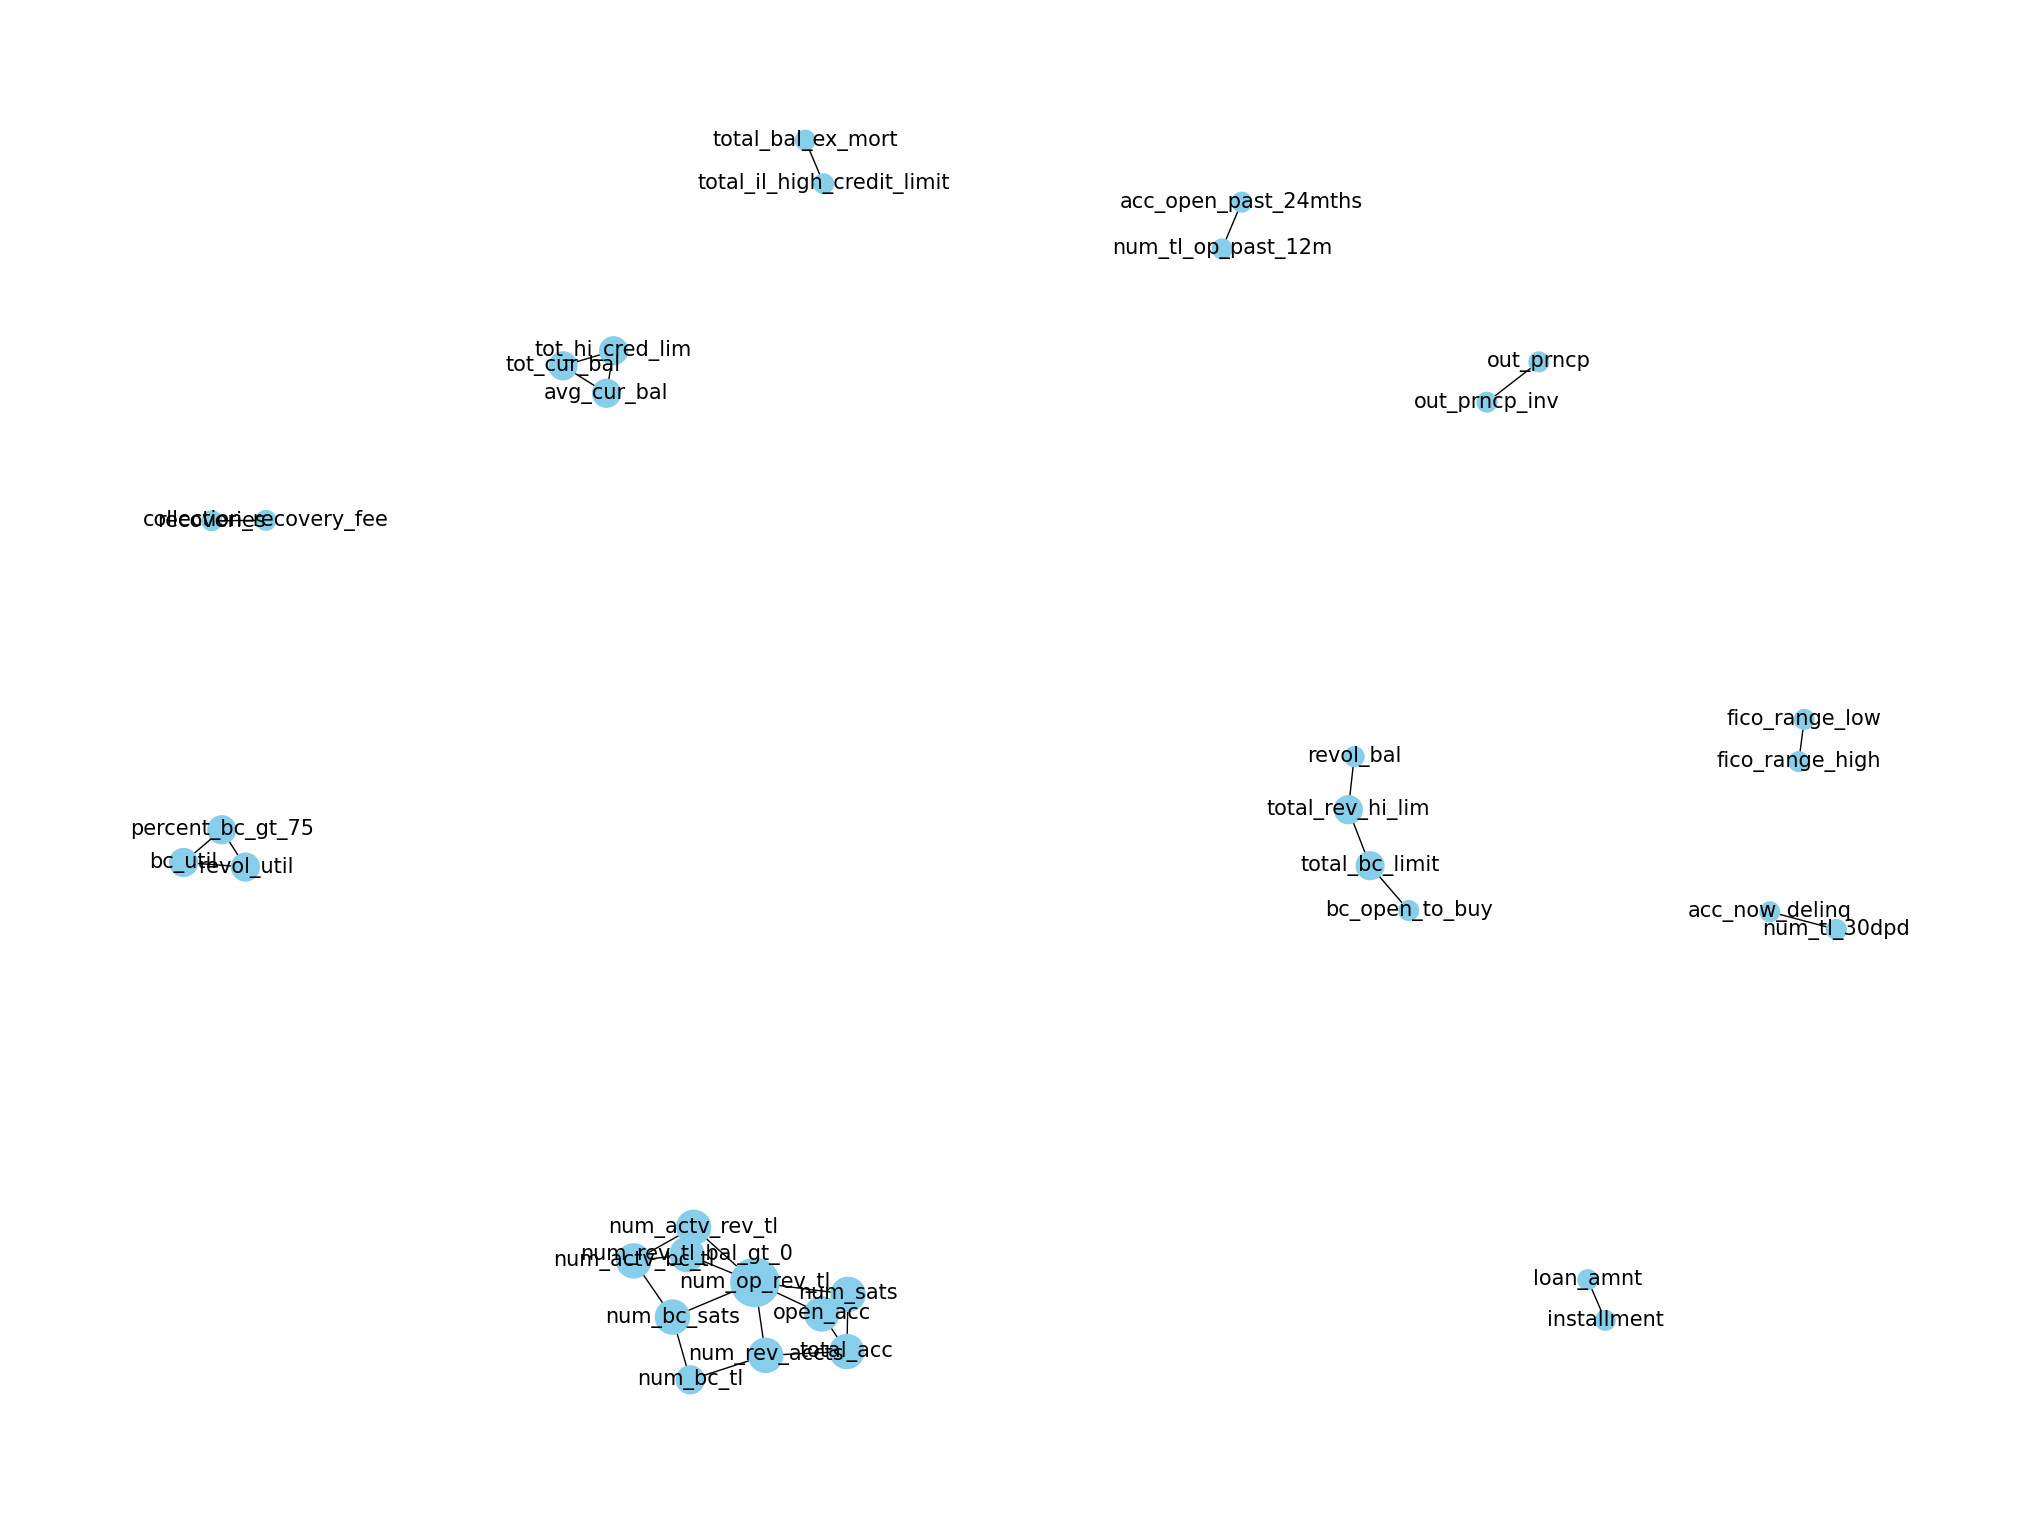

In [ ]:
from collections import defaultdict

correlation_count = defaultdict(int)
for feature in corr['feature1']:
    correlation_count[feature] += 1
for feature in corr['feature2']:
    correlation_count[feature] += 1

# sort by correlation count
sorted_correlation_count = sorted(correlation_count.items(), key=lambda x: x[1], reverse=True)

# plot a dependency graph
G = nx.Graph()
for feature, count in sorted_correlation_count:
    G.add_node(feature, weight=count)
for i in range(len(corr)):
    G.add_edge(corr['feature1'][i], corr['feature2'][i])
plt.figure(figsize=(20, 15))
nx.draw(G, with_labels=True, node_size=[G.nodes[node]['weight']*100 for node in G], node_color='skyblue', font_size=15)
plt.show()

The above graph is a dependency graph showing which features are correlated to which and what the correlation clusters, to see whcih column to remove so that the other correlations are reduced.

After looking into the data dictionary and which features have many correlated features associated with them.

I selected the columns: *num_op_rev_tl, installment, total_il_high_credit_limit, total_bc_limit, total_rev_hi_lim, num_tl_30dpd, out_prncp_inv, num_tl_op_past_12m, collection_recovery_fee, recoveries, bc_util, tot_hi_cred_lim, tot_cur_bal, percent_bc_gt_75, num_actv_bc_tl, total_acc, num_bc_tl, num_rev_tl_bal_gt_0, num_actv_rev_tl, num_sats*

In [ ]:
accepted_df.drop(['num_op_rev_tl', 'installment', 'total_il_high_credit_limit', 'total_bc_limit', 'total_rev_hi_lim', 'num_tl_30dpd', 'out_prncp_inv', 'num_tl_op_past_12m', 'collection_recovery_fee', 'recoveries', 'bc_util', 'tot_hi_cred_lim', 'tot_cur_bal', 'percent_bc_gt_75', 'num_actv_bc_tl', 'total_acc', 'num_bc_tl', 'num_rev_tl_bal_gt_0', 'num_actv_rev_tl', 'num_sats'], axis=1, inplace=True)

## EDA

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
profile = ProfileReport(accepted_df, minimal=True)
profile.to_file("output.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Above I have used an auto EDA tool, to do basic EDA for the many features we have in the dataset. So that I can get some insight into which features to do more EDA at.

### EDA based on some questions

I have picked the loan_status column to be the feature I will use for prediction.

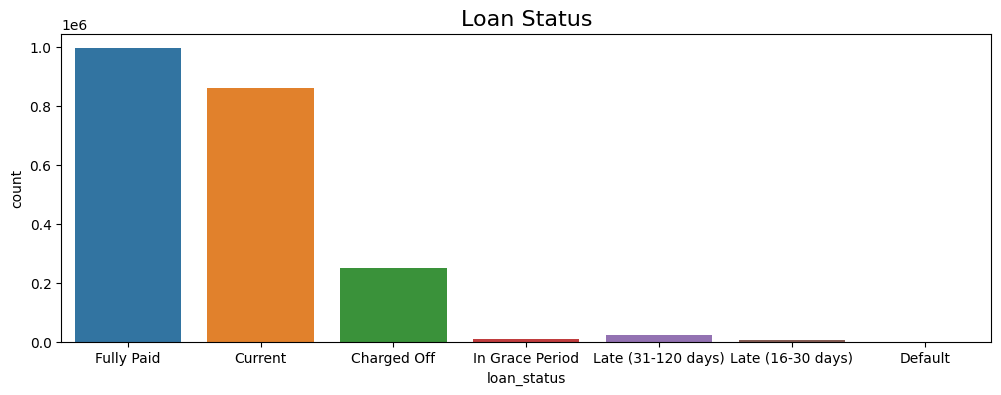

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(x='loan_status', data=accepted_df)
plt.title('Loan Status', fontsize=16)
plt.show()

There are many fully paid loan statuses next to it being Current.

Below is the meaning of all loan statuses:
- **Fully Paid** - the loan has been fully repaid, either at the end of the loan term or earlier because of prepayment.
- **Current** - the loan is up to date on all outstanding payments.
- **Charged Off** - LendingClub charges off a loan when we no longer reasonably expect further payments. Generally, charge-offs occur no later than 30 days after the loan enters Default status. Once a loan is charged off, the remaining principal balance of the Note is deducted from the account balance.
- **In Grace Period** - the loan is past due but within the 15-day grace period. LendingClub sends reminders to the member that their loan payment is past due.
- **Late (31–120)** - the loan hasn’t been current for 31–120 days. This is the second tranche of loan delinquency.
- **Late (16-30)** - the loan hasn’t been current for 16–30 days. This is the first tranche of loan delinquency.
- **Default** - the loan has not been current for more than 120 days. A loan in default status still appears in your Notes, but at this point, in most cases, LendingClub will begin the process to charge off the loan.

Debt-to-Income Influence on loan statuses.

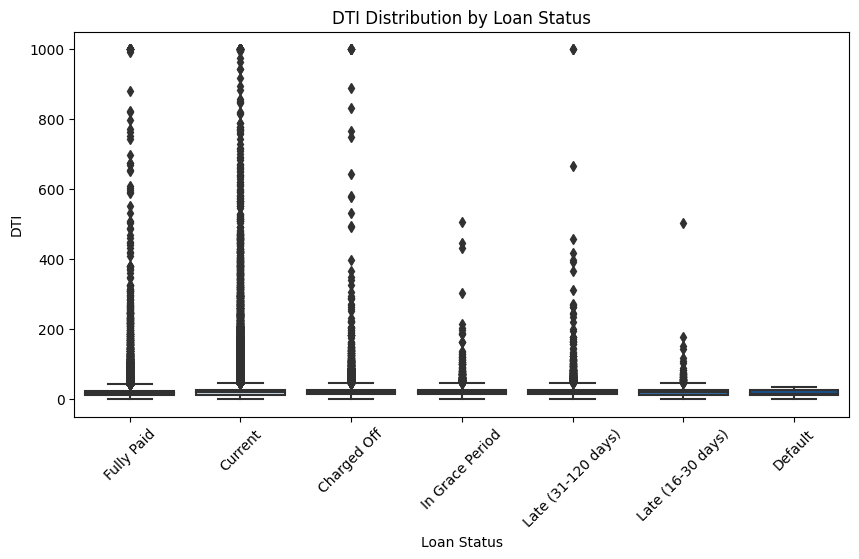

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=accepted_df, x='loan_status', y='dti', palette='Blues')
plt.title('DTI Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('DTI')
plt.xticks(rotation=45)
plt.show()

Higher DTI ratio doesn't necessarily mean we will get a fully paid loan status at the end of the day, beacuase we are also seeing some higher DTI ratios to charged off loans.

How is loan grade related to the different loan statuses.

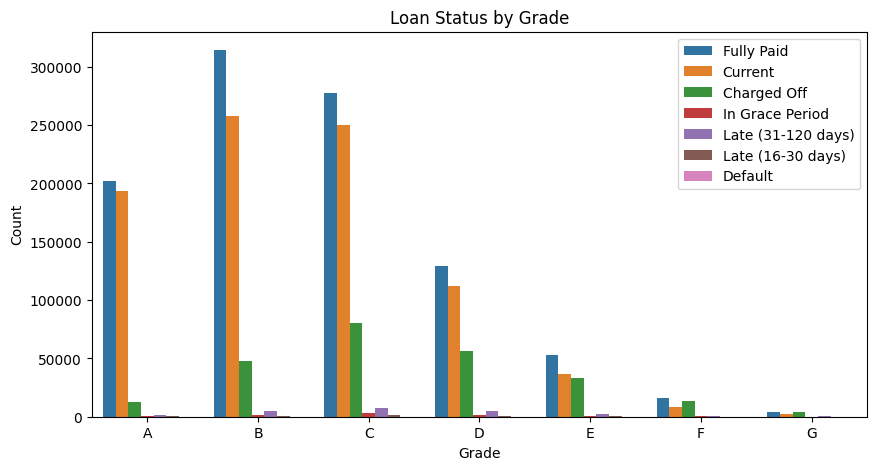

In [ ]:
plt.figure(figsize=(10,5))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(data=accepted_df, x='grade', hue='loan_status', order=grade_order)
plt.title('Loan Status by Grade')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

As the loan grades increase the number of Charged off loan statuses also increase, which shows higher loan grade values are actually riskier.

installments vs loan status
"installment" refers to a scheduled payment that a borrower makes to repay their loan. Installments are regular, fixed payments that borrowers agree to make at specific intervals, typically on a monthly basis, until the loan is fully repaid.

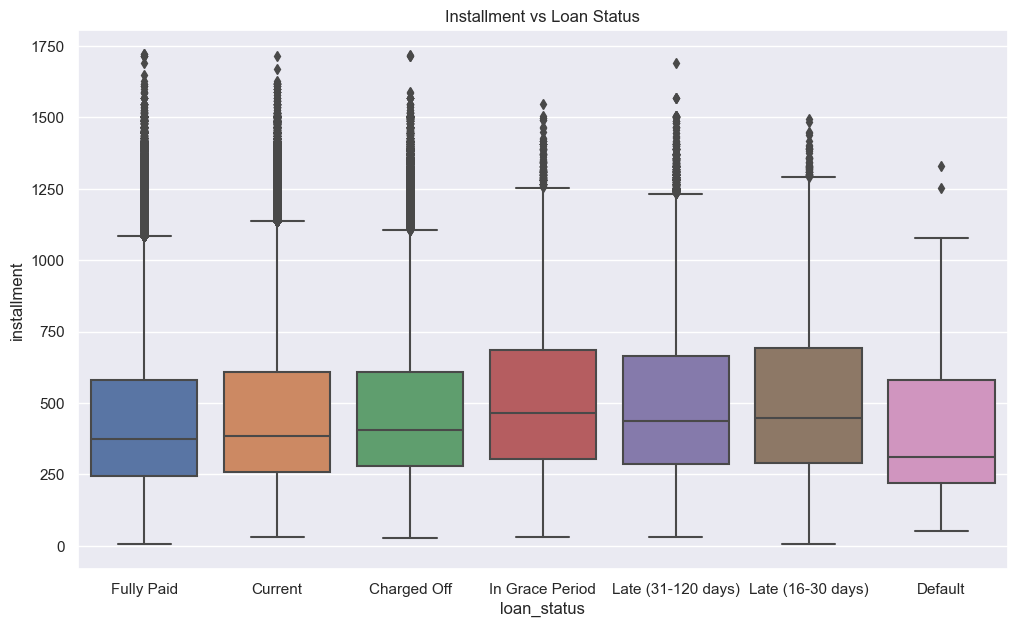

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='loan_status', y='installment', data=df_raw)
plt.title('Installment vs Loan Status')
plt.show()

Installment fees look a little higher on In Grace period and Late statuses.

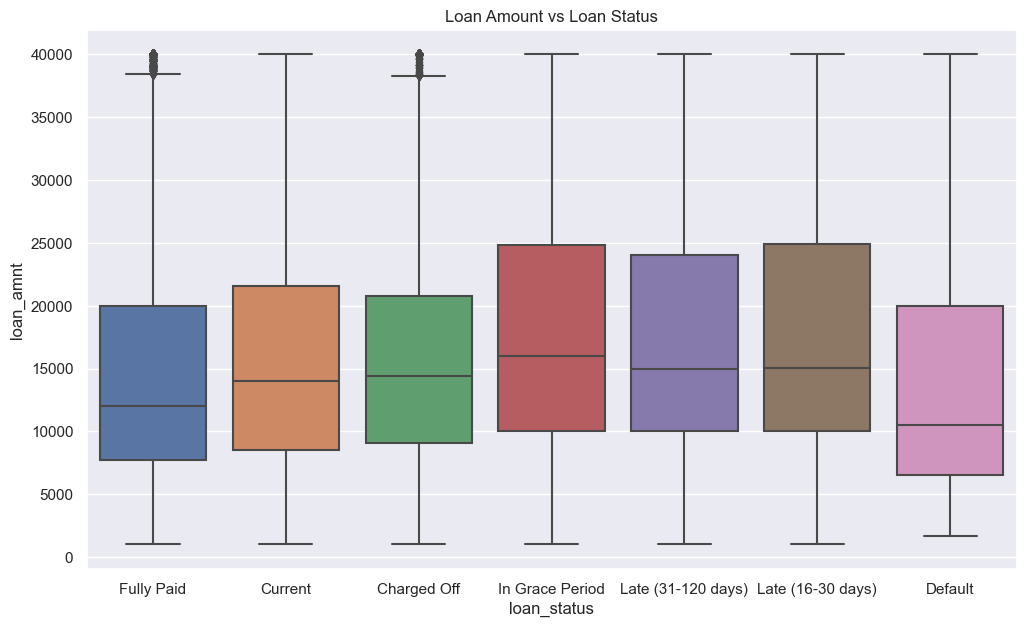

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='loan_status', y='loan_amnt', data=df_raw)
plt.title('Loan Amount vs Loan Status')
plt.show()

Here as well loan statuses like In grace period and Late received higher loan amounts.

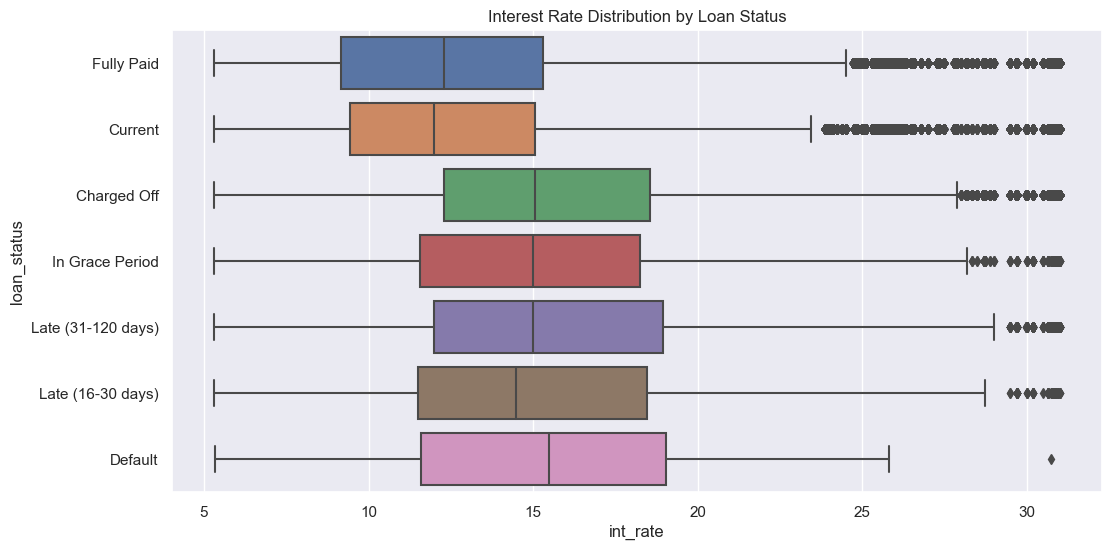

In [ ]:
sns.boxplot(x=df_raw.int_rate, y=df_raw.loan_status.astype(str))
df_raw.groupby(['loan_status'])['int_rate'].describe()
plt.title('Interest Rate Distribution by Loan Status')
plt.show()

Apart from Fully paid and Current loan statuses, other loan statuses have higher interest rates.

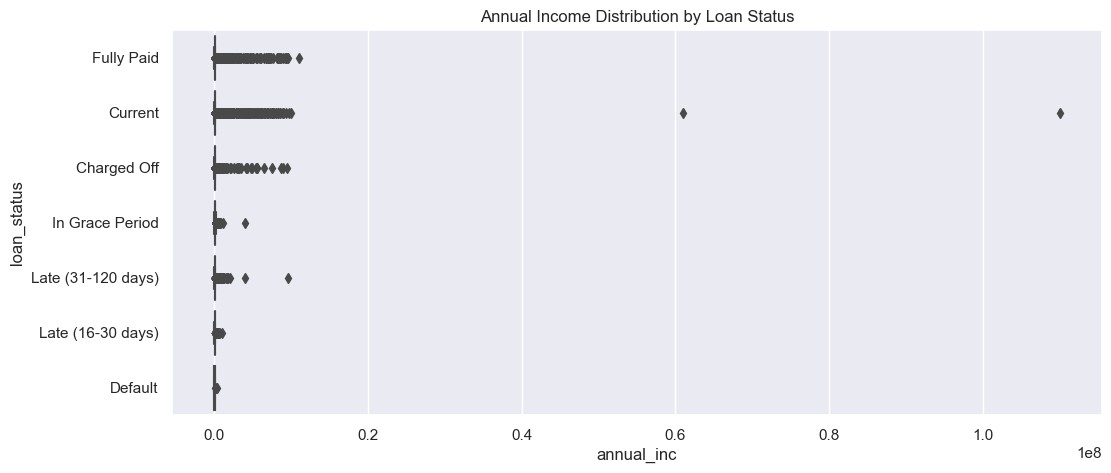

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df_raw.annual_inc, y=df_raw.loan_status.astype(str))
df_raw.groupby(['loan_status'])['annual_inc'].describe()
plt.title('Annual Income Distribution by Loan Status')
plt.show()

Looking at the above plot we can see that Annual Incomes are higher on Fully Paid, Current, and Charges off loan statuses which does not give us a clear distinction between the different loan statuses.

Geographical Impact: Is there a synergistic relationship between borrower location and loan outcomes?

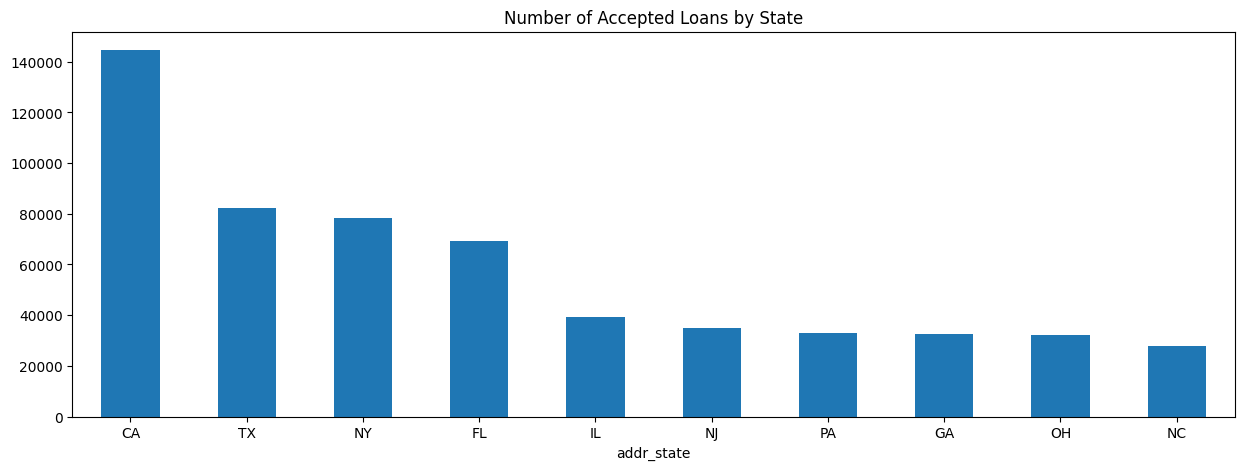

In [ ]:
accepted_loans = df_raw[df_raw['loan_status'] == 'Fully Paid'].groupby('addr_state').count().sort_values(ascending=False, by='zip_code')['zip_code']
accepted_loans.head(10).plot(kind='bar', figsize=(15, 5), title='Number of Accepted Loans by State')
plt.xticks(rotation=0)
plt.show()

We see that there are more accepted loans in the state California.

What is the distribution of loan amounts and interest rates across different states? 

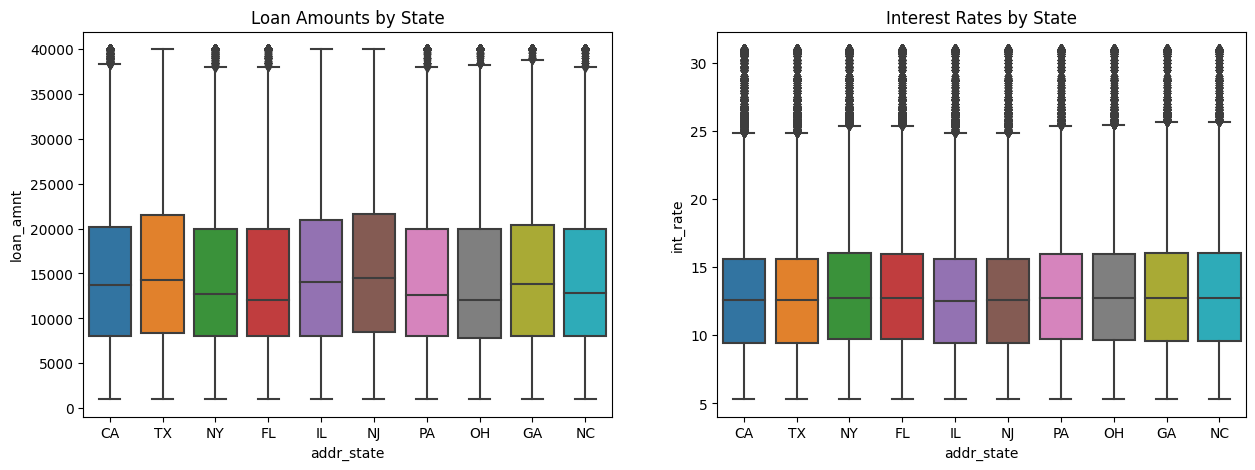

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='addr_state', y='loan_amnt', data=df_raw, order=df_raw['addr_state'].value_counts().sort_values(ascending=False).iloc[:10].index)
plt.title('Loan Amounts by State')
plt.subplot(1, 2, 2)
sns.boxplot(x='addr_state', y='int_rate', data=df_raw, order=df_raw['addr_state'].value_counts().sort_values(ascending=False).iloc[:10].index)
plt.title('Interest Rates by State')
plt.show()

For loan amounts it looks mostly similar for all the states we see here. Altough there are even more higher loan amount for some states.

For interset rate by state we can also say that it mostly similar for the states we see here.

Interest Rate and Loan Grade Connection: How do borrower attributes (e.g., credit score, income) synergize with loan grade to determine the interest rate? Are there instances where certain borrower segments receive more favorable rates for the same loan grade?

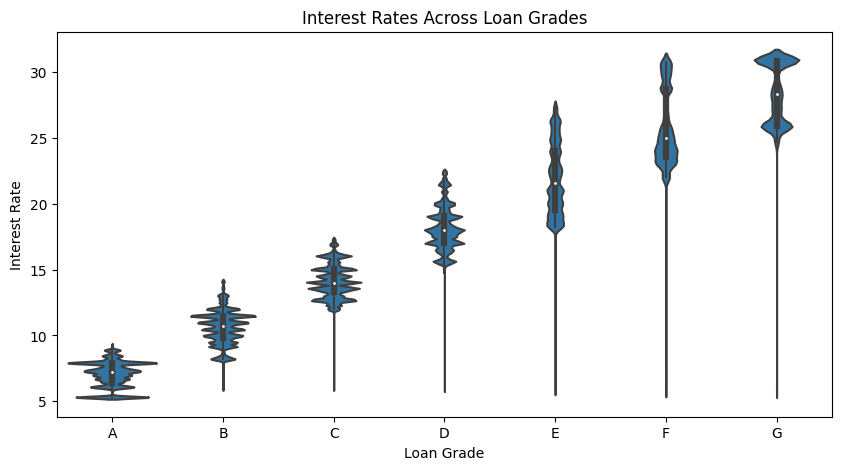

In [ ]:
plt.figure(figsize = [10, 5])
base_color = sns.color_palette()[0]
grade_order = ['A','B','C','D','E','F','G']
sns.violinplot(data = accepted_df, x = 'grade', y = 'int_rate', color = base_color, order = grade_order)
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.title('Interest Rates Across Loan Grades')
plt.show()

We can see that as loan grades increase interest rate also increases, which shows higher loan status will have higher interest rates. Usually lower loan grades are less risky and show lower loss rates.

How does the interest rate vary with the loan grade and term? 

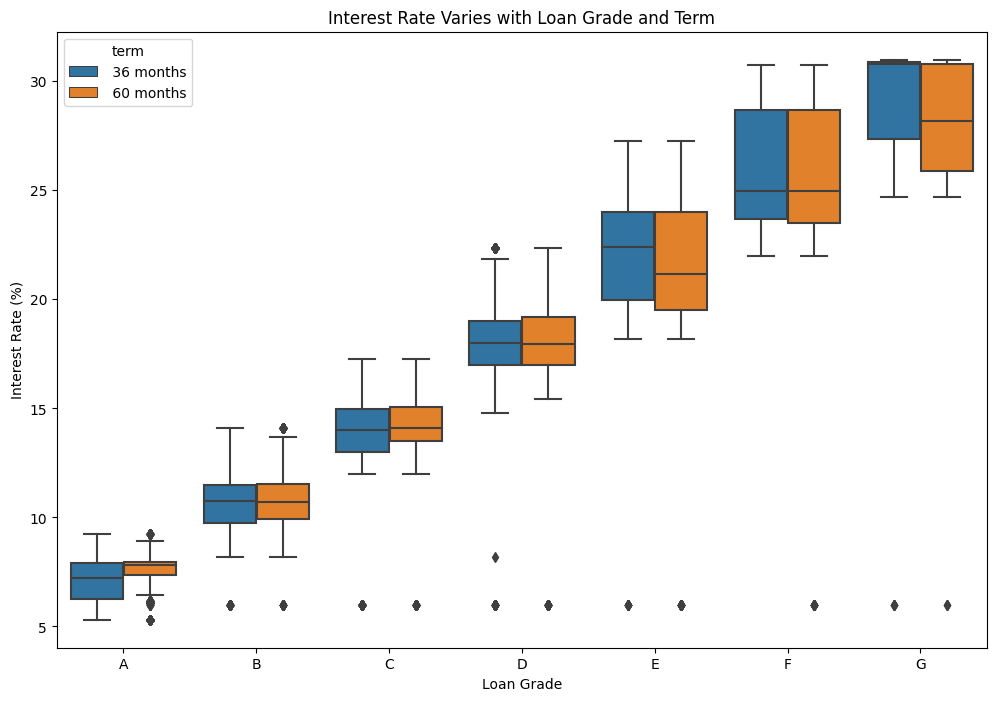

In [ ]:
plt.figure(figsize=(12, 8))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.boxplot(x='grade', y='int_rate', hue='term', data=accepted_df, order=grade_order)
plt.title('Interest Rate Varies with Loan Grade and Term')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate (%)')
plt.show()

As we can see from the diagram above as the laon grades keep on increasing the term 60 months increases gradually, which confirms the above plots information higher loan grades are actually worse.

How does the borrower's credit score affect the loan amount? 

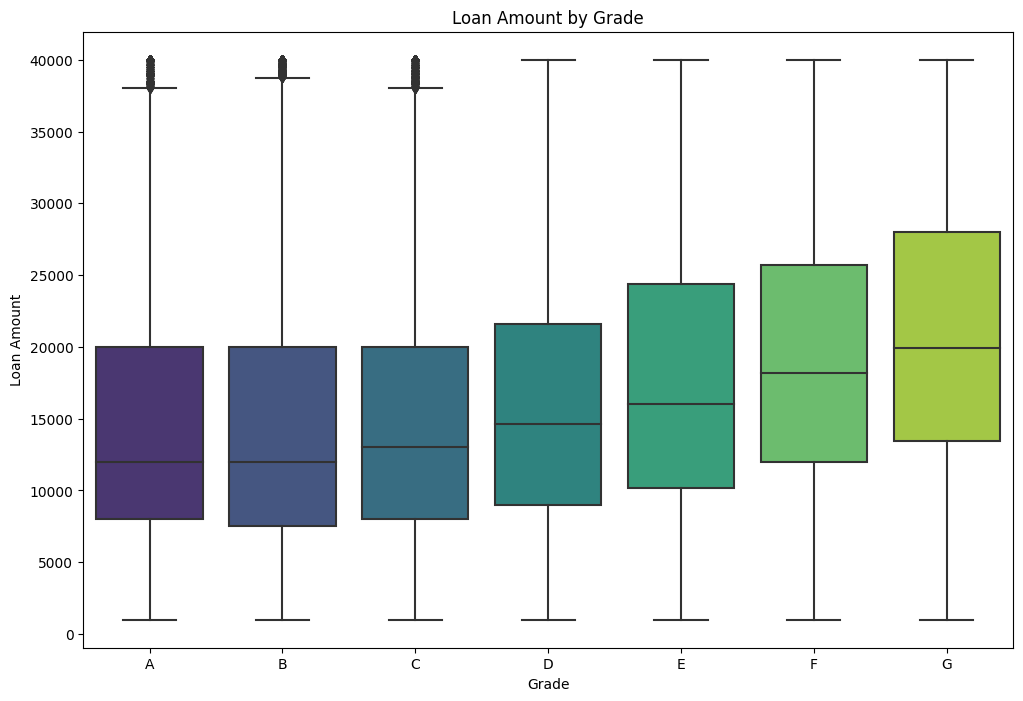

In [ ]:
plt.figure(figsize=(12, 8))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.boxplot(x='grade', y='loan_amnt', data=accepted_df, palette='viridis', order=grade_order)
plt.title('Loan Amount by Grade')
plt.xlabel('Grade')
plt.ylabel('Loan Amount')
plt.show()

Surprisingly in the above plot we see that higher loan grades recieve higher amounts of loans even though they are the riskier type of borrowers.

What is the distribution of loan amounts and interest rates for different loan terms? 

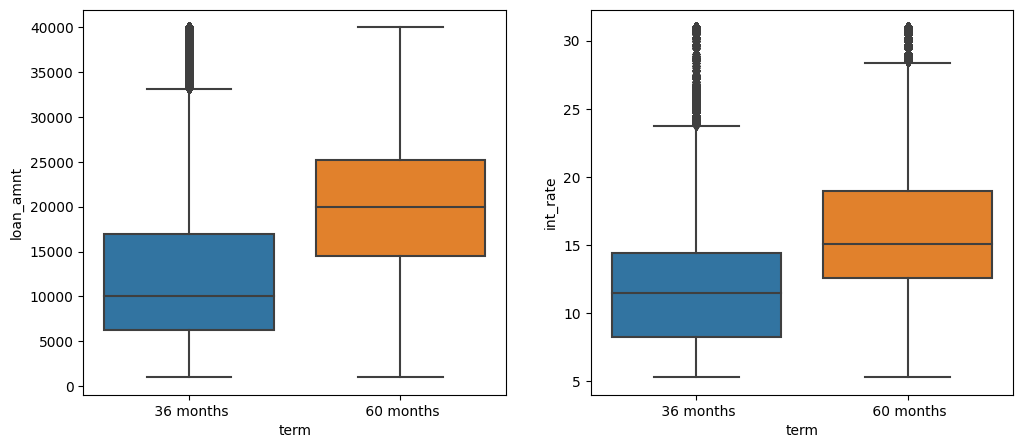

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='term', y='loan_amnt', data=accepted_df)
plt.subplot(1, 2, 2)
sns.boxplot(x='term', y='int_rate', data=accepted_df)
plt.show()

From the above plots we can see that longer loan terms have higher loan amounts and at the same time higher interest rates as well.

A payment plan refers to the structured schedule of payments that a borrower agrees to when they take out a loan in lending club.

"n": This typically stands for "no" or "none." It generally indicates that a particular feature or option is not present or not applicable to the loan. 

"y": This stands for "yes. "y" indicates that a particular feature or option is present or applicable to the loan. 

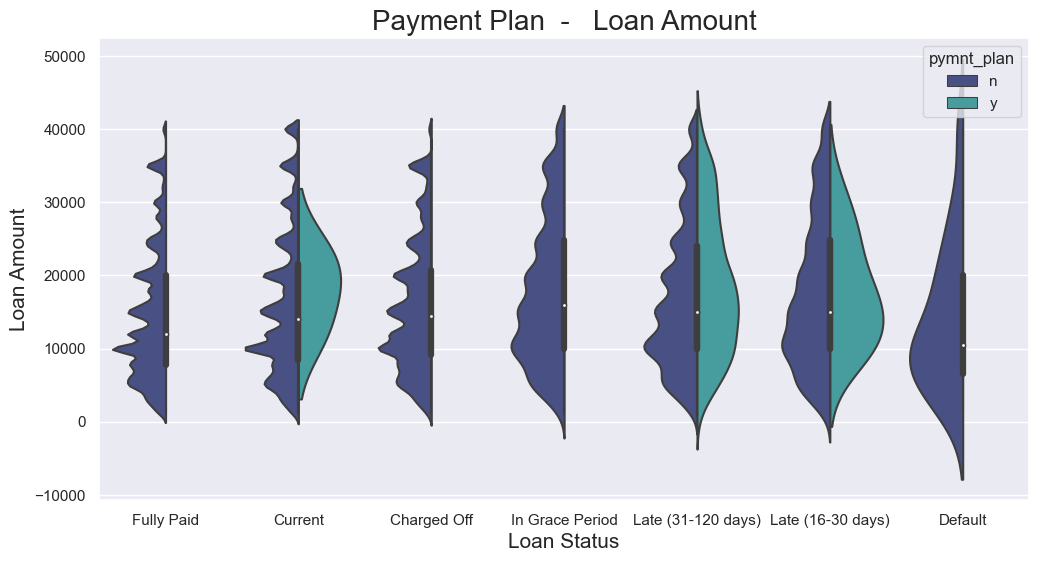

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})
sns.violinplot(x='loan_status',y='loan_amnt',data=accepted_df, hue='pymnt_plan', split=True,palette='mako')
plt.title(str('Payment Plan')+"  -   "+str('Loan Amount'), fontsize=20)
plt.xlabel('Loan Status', fontsize=15)
plt.ylabel('Loan Amount', fontsize=15)
plt.show()

Above we can see that most loan statuses have no payment plan associated with them, and for most loan amounts we can also see that there are not many payment plans.

In LendingClub, a "hardship flag" refers to a status that can be applied to a loan when a borrower is experiencing financial difficulties or facing hardships that make it challenging for them to meet their loan obligations as originally agreed.

"Y" (Yes) Hardship Flag: When a borrower is facing financial challenges and has entered into a hardship plan with LendingClub, the "Y" flag is applied to their account. 

"N" (No) Hardship Flag: If a borrower is not enrolled in a hardship plan and is making regular payments according to the original loan terms.

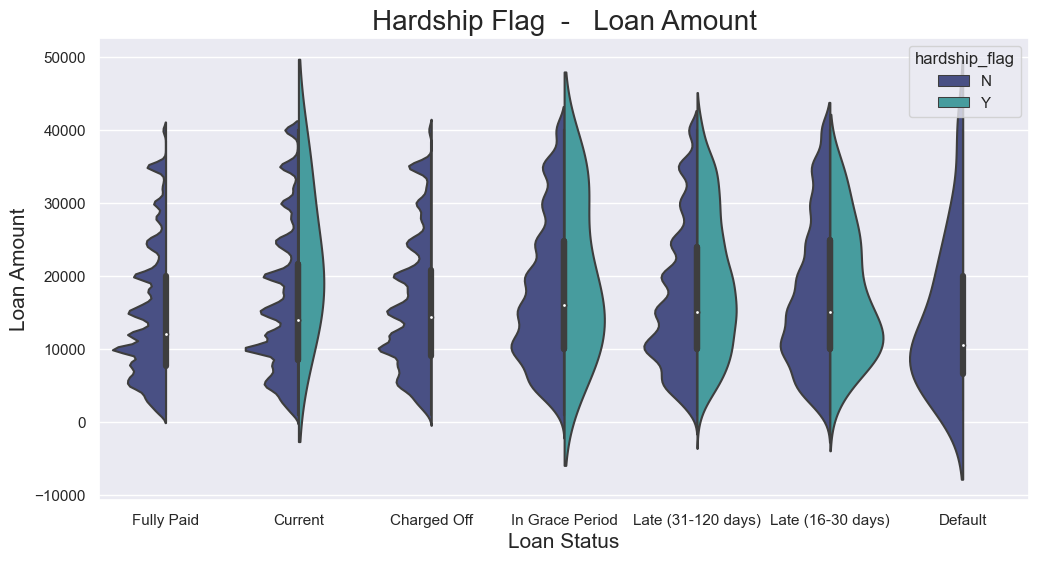

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})
sns.violinplot(x='loan_status',y='loan_amnt',data=accepted_df, hue='hardship_flag', split=True,palette='mako')
plt.title(str('Hardship Flag')+"  -   "+str('Loan Amount'), fontsize=20)
plt.xlabel('Loan Status', fontsize=15)
plt.ylabel('Loan Amount', fontsize=15)
plt.show()

Above we see more yes's on the laon statuses In Grace Period, and Late which makes sense that people who have hardship flags associated to thier loans are either in a grace perios or late. For loan amounts we don't see that much of a significant difference.

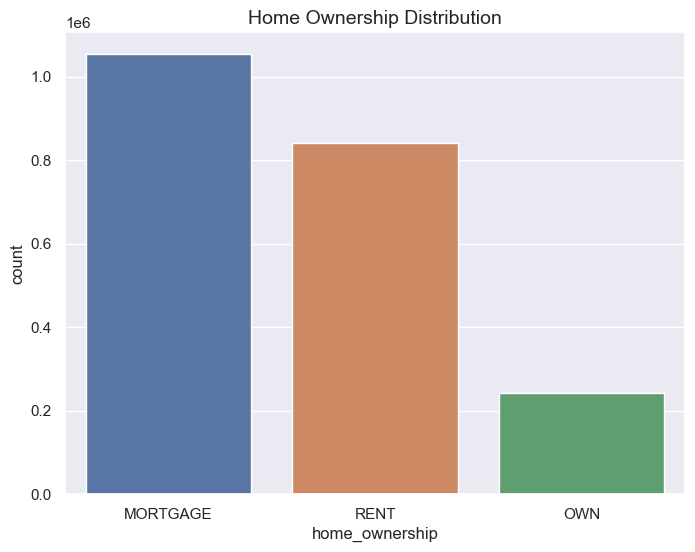

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='home_ownership', data=df_raw[df_raw['home_ownership'].isin(['MORTGAGE', 'RENT', 'OWN'])])
plt.title('Home Ownership Distribution', fontsize=14)
plt.show()

Mortgage: When a borrower has a "Mortgage," it means they own a home and have taken out a loan (mortgage) to finance the purchase of that home. 

Rent: If a borrower is "Renting," it means they do not own a home and are paying to live in a property owned by someone else. 

Own: "Own" refers to the situation where a borrower owns their home outright without any mortgage or loan associated with it.

Above we see that most people have mortgaged thier homes for loan.

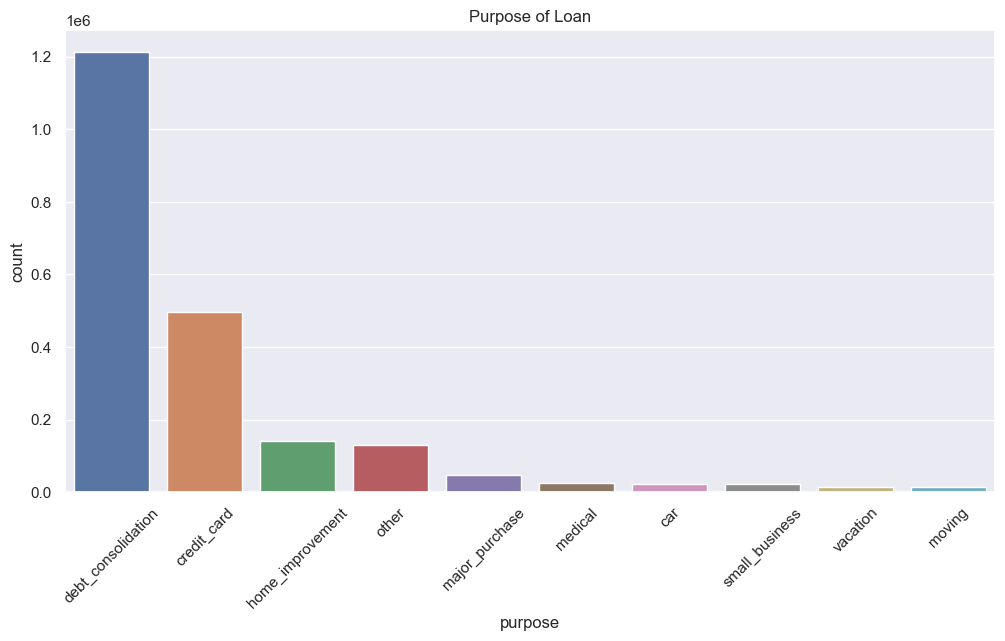

In [ ]:
sns.countplot(x='purpose', data=df_raw, order=df_raw['purpose'].value_counts().index[:10])
plt.xticks(rotation=45)
plt.title('Purpose of Loan')
plt.show()

Majority of the loan purposes in this dataset are of the purpose of Consolidating an existing loan, which shows many borrowers, borrow again to pay existing debts.

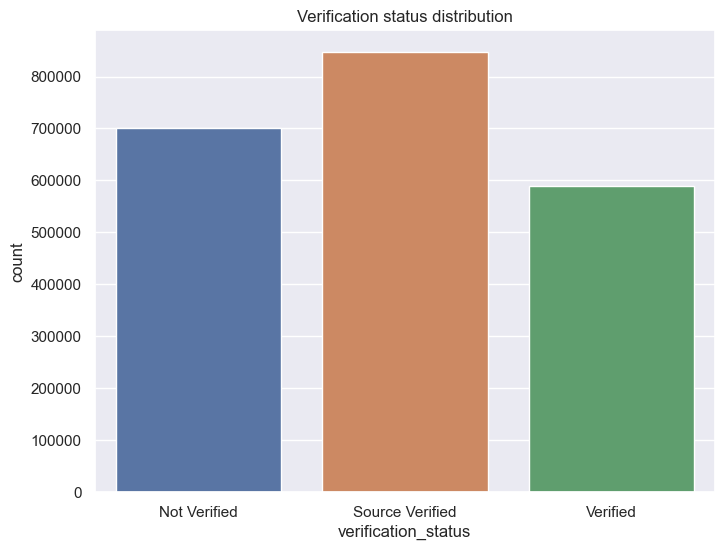

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='verification_status', data=df_raw)
plt.title('Verification status distribution')
plt.show()

Most individuals are source verified in this dataset which refers to the lender has receiving and verifying documentation directly from the source of the information. 

Can we identify a combination of borrower attributes that consistently leads to a loan being fully paid?

Let's use :
- loan_amnt: The loan amount requested by the borrower. Higher loan amounts might be associated with higher risk and more stringent approval criteria.
- term: The length of the loan term (e.g., 36 months or 60 months). Longer terms might lead to different approval rates and outcomes.
- int_rate: The interest rate assigned to the loan. This could be a key factor in loan affordability and repayment.
- grade and sub_grade: Lending Club's assigned loan grade and subgrade. These reflect the risk assessment of the borrower and could play a role in approval rates.
- annual_inc: The borrower's annual income. Higher income might indicate better ability to repay the loan.
- verification_status: Indicates whether the borrower's income has been verified by Lending Club.
- purpose: The purpose for which the loan is being taken. Different loan purposes could have varying default rates.

In [ ]:
cols = ['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'verification_status', 'purpose', 'loan_status']
attrs_df = df_raw[cols].copy()

attrs_df = pd.get_dummies(attrs_df, columns=['term', 'grade', 'sub_grade', 'verification_status', 'purpose', 'loan_status'])

corr = attrs_df.corr()

corr['loan_status_Fully Paid'].sort_values(ascending=False).head(10)

loan_status_Fully Paid          1.000000
term_ 36 months                 0.177484
grade_B                         0.045435
verification_status_Verified    0.037956
sub_grade_B3                    0.030267
sub_grade_A5                    0.028597
grade_A                         0.025824
sub_grade_B2                    0.020444
sub_grade_B1                    0.016037
purpose_debt_consolidation      0.016005
Name: loan_status_Fully Paid, dtype: float64

We don't really see a relationship between loan status and the other features we checked its correlation against.

## Statistical Inference

In [ ]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.weightstats import DescrStatsW

In [ ]:
def perform_statistical_tests(population1, population2, alpha=0.05):
    # Perform the t-test
    t, p_ttest = ttest_ind(population1, population2, equal_var=False)

    # Perform the z-test
    z, p_ztest = ztest(population1, x2=population2, value=0, alternative='two-sided')

    # Calculate confidence intervals
    ci_population1 = DescrStatsW(population1).tconfint_mean()
    ci_population2 = DescrStatsW(population2).tconfint_mean()

    # Check the p-values and print results
    results = {
        't-test': {
            't-statistic': t,
            'p-value': p_ttest,
            'hypothesis': 'Rejected' if p_ttest < alpha else 'Accepted'
        },
        'z-test': {
            'z-statistic': z,
            'p-value': p_ztest,
            'hypothesis': 'Rejected' if p_ztest < alpha else 'Accepted'
        },
        'confidence_intervals': {
            'population1': ci_population1,
            'population2': ci_population2
        }
    }
    
    return results

def print_results(results):
    print('t-test results:')
    print(results['t-test'])

    print('\nz-test results:')
    print(results['z-test'])

    print('\nConfidence interval for population1:', results['confidence_intervals']['population1'])
    print('Confidence interval for population2:', results['confidence_intervals']['population2'])


- Null Hypothesis (H0): The average interest rate for fully paid loans is the same as the average interest rate for charged-off loans.
- Alternative Hypothesis (H1): The average interest rate for fully paid loans is different from the average interest rate for charged-off loans.

In [ ]:
population1 = df_raw[df_raw['loan_status'] == 'Fully Paid']['int_rate']
population2 = df_raw[df_raw['loan_status'] == 'Charged Off']['int_rate']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': -285.01840835006686, 'p-value': 0.0, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': -298.5586377548219, 'p-value': 0.0, 'hypothesis': 'Rejected'}

Confidence interval for population1: (12.624392260777801, 12.64226717518826)
Confidence interval for population2: (15.712509117074195, 15.751193971721648)


- Null Hypothesis (H0): There is no significant difference in the loan amounts between different loan grades (e.g., A, B, C, etc.).
- Alternative Hypothesis (H1): There is a significant difference in the loan amounts between different loan grades.
Features: grade, loan_amnt (loan amount).

In [ ]:
population1 = df_raw[df_raw['grade'] == 'A']['loan_amnt']
population2 = df_raw[df_raw['grade'] == 'B']['loan_amnt']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': 28.35268991112626, 'p-value': 9.348320667375177e-177, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': 28.45117195651029, 'p-value': 4.713079011694164e-178, 'hypothesis': 'Rejected'}

Confidence interval for population1: (14795.813907807786, 14851.833086447821)
Confidence interval for population2: (14283.903108406, 14328.443914619842)


- Null Hypothesis (H0): The average annual income of borrowers with a home ownership status of "OWN" is the same as the average annual income of borrowers with a home ownership status of "RENT".
- Alternative Hypothesis (H1): The average annual income of borrowers with a home ownership status of "OWN" is different from the average annual income of borrowers with a home ownership status of "RENT".

In [ ]:
population1 = df_raw[df_raw['home_ownership'] == 'OWN']['annual_inc']
population2 = df_raw[df_raw['home_ownership'] == 'RENT']['annual_inc']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': 26.879661782823202, 'p-value': 4.684313838236261e-159, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': 21.054489919647967, 'p-value': 2.0801037418475444e-98, 'hypothesis': 'Rejected'}

Confidence interval for population1: (72941.53888697719, 73619.14692789412)
Confidence interval for population2: (66891.26793375057, 67467.81786974006)


In [ ]:
'''
Null Hypothesis (H0): The average debt-to-income (DTI) ratio for loans with different loan purposes (e.g., debt consolidation, credit card, etc.) is the same.
Alternative Hypothesis (H1): The average debt-to-income (DTI) ratio for loans with different loan purposes is different.
Features: purpose (loan purpose), dti (debt-to-income ratio).
'''

population1 = df_raw[df_raw['purpose'] == 'debt_consolidation']['dti']
population2 = df_raw[df_raw['purpose'] == 'credit_card']['dti']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': 19.638625428877123, 'p-value': 7.532829827697242e-86, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': 19.69375821919098, 'p-value': 2.4390449767058898e-86, 'hypothesis': 'Rejected'}

Confidence interval for population1: (19.56148930386161, 19.612272470078754)
Confidence interval for population2: (19.072981193026404, 19.15280611508879)


## Feature Engineering

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score, recall_score, f1_score
from sklearn.mixture import GaussianMixture

import xgboost as xgb
import catboost as cb
import optuna
import joblib
import shap
import lime

Let's grab the categorical features

In [21]:
cat_features = []
for col in accepted_df.columns:
    if accepted_df[col].dtype == 'object':
        cat_features.append(col)

Let's only take the features that are necessary for one hot encoding

In [22]:
wanted = cat_features.copy()
wanted = [item for item in wanted if item not in ['purpose', 'sub_grade', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'loan_status']]

Let's drop those features

In [23]:
accepted_df = accepted_df.drop(['purpose', 'sub_grade', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], axis=1)

Now from the target class we will only take the Fully Paid and Charged Off loan statuses. For prediction.

- **Fully Paid** - the loan has been fully repaid, either at the end of the loan term or earlier because of prepayment.
- **Charged Off** - LendingClub charges off a loan when we no longer reasonably expect further payments. Generally, charge-offs occur no later than 30 days after the loan enters Default status. Once a loan is charged off, the remaining principal balance of the Note is deducted from the account balance.

In [24]:
accepted_df = accepted_df[accepted_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [73]:
X = accepted_df.drop('loan_status', axis=1)
y = accepted_df['loan_status']

Splitting our target from the rest.

Now we take the features we wanted and we encode them using one hot encoding

In [74]:
dummy_features = X[wanted]

In [75]:
one_hot_encoded = pd.get_dummies(dummy_features)

Now we will drop the original columns since we have the one hot encoded once.

In [76]:
X.drop(wanted, axis=1, inplace=True)

The we combine the one hot encoded features with the original dataframe.

In [77]:
X = pd.concat([X, one_hot_encoded], axis=1)

In [78]:
len(X.columns)

63

Since the target variable is also categorical, we can use a label encoder one of the two classes to convert it into a numerical column.

In [104]:
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

Class 0: 248155
Class 1: 995754


In [80]:
original_feature_names = X.columns.to_list()

Standardizing the data

In [81]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Then we split the data to train and test sets.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [82]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y, test_size=0.2, random_state=1234)

## Modelling

In [35]:
# Calculate the class imbalance ratio
class_counts = np.bincount(y_train)
imbalance_ratio = class_counts[0] / class_counts[1]  

# Adjust the XGBoost model with class weight
xgb_model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    scale_pos_weight=imbalance_ratio
)

xgb_model.fit(X_train_std, y_train_std)

y_pred = xgb_model.predict(X_test_std)

In [36]:
print('Precision: %.3f' % precision_score(y_test_std, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test_std, y_pred))

Precision: 0.982
ROC AUC: 0.891


In [37]:
# Calculate class weights
class_counts = np.bincount(y_train_std)
total_samples = len(y_train_std)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

# Create the CatBoostClassifier with class weights
cat_model = cb.CatBoostClassifier(
    task_type="GPU",
    verbose=False,
    class_weights=class_weights  
)

# Fit the model
cat_model.fit(X_train_std, y_train_std)

# Predict and print classification report
y_pred = cat_model.predict(X_test_std)

In [38]:
print('Precision: %.3f' % precision_score(y_test_std, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test_std, y_pred))

Precision: 0.985
ROC AUC: 0.888


In [41]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    # Create and train XGBoost model
    model = xgb.XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, scale_pos_weight=imbalance_ratio)
    model.fit(X_train_std, y_train_std)
    
    # Predict on validation set
    y_pred = model.predict(X_test_std)
    
    # Calculate precision as the objective to optimize
    roc_auc = roc_auc_score(y_test_std, y_pred)
    return roc_auc

In [42]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Create an Optuna study object and optimize maximizing presicion
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best hyperparameters and their corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best ROC AUC:", best_accuracy)

Best Hyperparameters: {'eta': 0.22348108864970043, 'max_depth': 9, 'subsample': 0.9218901607481944, 'colsample_bytree': 0.8905861281084367, 'min_child_weight': 4}
Best Accuracy: 0.8927447265272274


In [83]:
xgb_optimized = xgb.XGBClassifier(eta=0.22348108864970043, max_depth=9, subsample=0.9218901607481944, colsample_bytree=0.8905861281084367,
                                  min_child_weight=4, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor', n_estimators=1000, scale_pos_weight=imbalance_ratio
                                  )
xgb_optimized.fit(X_train_std, y_train_std)
y_pred = xgb_optimized.predict(X_test_std)

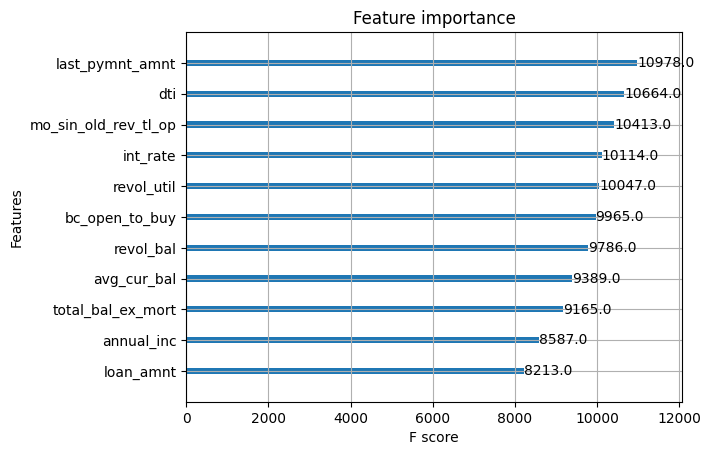

In [90]:
xgb_optimized.get_booster().feature_names = original_feature_names
xgb.plot_importance(xgb_optimized, max_num_features=11)
plt.show()

In [49]:
print('Precision: %.3f' % precision_score(y_test_std, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test_std, y_pred))

Precision: 0.961
ROC AUC: 0.878


## Dimesnionality Reduction

In [50]:
batches = 100
iPca = IncrementalPCA(n_components=63, whiten=True)
for batch in np.array_split(X_train, batches):
    iPca.partial_fit(batch)

X_reduced = iPca.transform(X_train)

In [51]:
cumulative_variance_ratio = np.cumsum(iPca.explained_variance_ratio_)

In [52]:
desired_threshold = 0.99
n_components = np.argmax(cumulative_variance_ratio >= desired_threshold) + 1
print(f"Number of components required to explain {desired_threshold*100}% of the variance: {n_components}")

Number of components required to explain 99.0% of the variance: 6


In [53]:
batches = 100
iPca_v2 = IncrementalPCA(n_components=n_components, whiten=True)
for batch in np.array_split(X_train, batches):
    iPca_v2.partial_fit(batch)

X_reduced_v2 = iPca_v2.transform(X_train)

In [54]:
loading_vectors = iPca_v2.components_
loading_vectors = loading_vectors.T
selected_features_indices = np.argsort(np.abs(loading_vectors), axis=0)[::-1]

n_selected_features = 10
selected_features = []
for component_indicies in selected_features_indices[:n_selected_features]:
    selected_features.extend(component_indicies)

selected_features = list(set(selected_features))
selected_feature_names = X_train.columns[selected_features]
print(selected_feature_names)

Index(['loan_amnt', 'annual_inc', 'dti', 'total_bal_ex_mort', 'fico_range_low',
       'fico_range_high', 'revol_bal', 'revol_util', 'last_pymnt_amnt',
       'tot_coll_amt', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt',
       'mo_sin_old_rev_tl_op'],
      dtype='object')


In [55]:
X_reduced = X[selected_feature_names.tolist()]

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=123)

In [63]:
xgb_model_reduced = xgb.XGBClassifier(
    tree_method='gpu_hist',
)

xgb_model_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = xgb_model_reduced.predict(X_test_reduced)

In [64]:
print('Precision: %.3f' % precision_score(y_test_std, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test_std, y_pred))

Precision: 0.961
ROC AUC: 0.878


In [96]:
# last_pymnt_amnt, dti, mo_sin_old_rev_tl_top, int_rate, revol_util, bc_open_to_buy, revol_bal, avg_cur_bal, total_bal_ex_mort, annual_inc, loan_mant

# Create a pipeline with a StandardScaler and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(eta=0.22348108864970043, max_depth=9, subsample=0.9218901607481944, colsample_bytree=0.8905861281084367,
                              min_child_weight=4, tree_method='gpu_hist', gpu_id=0, scale_pos_weight=imbalance_ratio))
])

# create train and test sets using the above list of features
X_smaller = X[['last_pymnt_amnt', 'dti', 'mo_sin_old_rev_tl_op', 'int_rate', 'revol_util',
               'bc_open_to_buy', 'revol_bal', 'avg_cur_bal', 'total_bal_ex_mort', 'annual_inc', 'loan_amnt']]

# create train and test sets using the above list of features
X_train_smaller, X_test_smaller, y_train_smaller, y_test_smaller = train_test_split(
    X_smaller, y, test_size=0.2, random_state=123)

# Fit the pipeline to the train set
pipeline.fit(X_train_smaller, y_train_smaller)

# Predict the labels of the test set
y_pred_smaller = pipeline.predict(X_test_smaller)

In [105]:
joblib.dump(X_test_smaller, 'X_test_smaller.joblib')

['X_test_smaller.joblib']

In [98]:
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [102]:
model = joblib.load('pipeline.joblib')
# the the first row of the test set
input_data = X_test_smaller.iloc[0]
model.predict([input_data])

array([1])

## Clustering for Customer Segmentation

In [82]:
accepted_df['term'] = accepted_df['term'].apply(lambda x: 60 if x == ' 60 months' else 36)

In [83]:
# Select relevant features (you might need to adjust this based on your dataset)
features = ['loan_amnt', 'annual_inc', 'int_rate', 'term', 'dti']

# Filter out the data for charged off and fully paid loans
charged_off_data = accepted_df[accepted_df['loan_status'] == 'Charged Off'][features]
fully_paid_data = accepted_df[accepted_df['loan_status'] == 'Fully Paid'][features]

# Standardize the data
scaler = StandardScaler()
charged_off_scaled = scaler.fit_transform(charged_off_data)
fully_paid_scaled = scaler.fit_transform(fully_paid_data)

# Combine the data for clustering
combined_data = np.vstack((charged_off_scaled, fully_paid_scaled))

In [46]:
lowest_bic = np.infty
best_n_components_bic = 0

lowest_aic = np.infty
best_n_components_aic = 0

n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(combined_data)

    bic = gmm.bic(combined_data)
    if bic < lowest_bic:
        lowest_bic = bic
        best_n_components_bic = n_components

    aic = gmm.aic(combined_data)
    if aic < lowest_aic:
        lowest_aic = aic
        best_n_components_aic = n_components

In [58]:
optimal_clusters_bic = best_n_components_bic
optimal_clusters_aic = best_n_components_aic

print("Optimal number of clusters (BIC):", optimal_clusters_bic)
print("Optimal number of clusters (AIC):", optimal_clusters_aic)

Optimal number of clusters (BIC): 7
Optimal number of clusters (AIC): 7


In [84]:
num_clusters = 7
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(combined_data)

# Assign clusters to the original data points
charged_off_labels = gmm.predict(charged_off_scaled)
fully_paid_labels = gmm.predict(fully_paid_scaled)

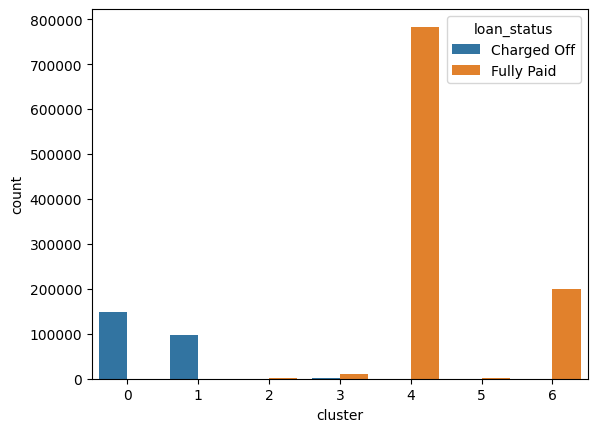

In [85]:
# Create a dataframe with cluster assignments and loan status
charged_off_clusters = pd.DataFrame({'cluster': charged_off_labels, 'loan_status': 'Charged Off'})
fully_paid_clusters = pd.DataFrame({'cluster': fully_paid_labels, 'loan_status': 'Fully Paid'})

# Concatenate the dataframes
combined_clusters = pd.concat([charged_off_clusters, fully_paid_clusters])

# Plot the result
sns.countplot(x="cluster", hue="loan_status", data=combined_clusters)
plt.show()

In [86]:
cluster_features = pd.concat([accepted_df[features], pd.Series(gmm.predict(combined_data), name='cluster')], axis=1)
cluster_feature_means = cluster_features.groupby('cluster').mean()

print("Mean Feature Values for Each Cluster:")
print(cluster_feature_means)

Mean Feature Values for Each Cluster:
            loan_amnt    annual_inc   int_rate       term        dti
cluster                                                             
0.0      14608.879358  77063.375851  12.169422  41.710163  18.972184
1.0      14651.058231  77656.318264  12.174728  41.728295  18.963024
2.0      14517.505924  77900.241943  13.012488  41.317536  18.406754
3.0      14540.130808  76338.497773  12.808299  41.913315  18.936602
4.0      14648.465354  76997.814563  12.950100  41.767955  18.863450
5.0      14471.224832  76347.956421  13.031924  41.476510  18.927170
6.0      14620.134573  77240.793436  12.957916  41.704107  18.940824


In [87]:
cluster_feature_max = cluster_features.groupby('cluster').max()
cluster_feature_min = cluster_features.groupby('cluster').min()

print("Maximum Feature Values for Each Cluster:")
print(cluster_feature_max)

print("\nMinimum Feature Values for Each Cluster:")
print(cluster_feature_min)

Maximum Feature Values for Each Cluster:
         loan_amnt  annual_inc  int_rate  term     dti
cluster                                               
0.0        35000.0   9000000.0     28.99  60.0  999.00
1.0        35000.0   9500000.0     28.99  60.0  672.52
2.0        40000.0    721000.0     30.99  60.0   43.84
3.0        40000.0   1300000.0     30.99  60.0  170.12
4.0        40000.0   9225000.0     30.99  60.0  999.00
5.0        38400.0    400000.0     30.94  60.0   78.20
6.0        40000.0  10999200.0     30.99  60.0  999.00

Minimum Feature Values for Each Cluster:
         loan_amnt  annual_inc  int_rate  term   dti
cluster                                             
0.0         1000.0      1770.0      5.32  36.0  0.00
1.0         1000.0      1200.0      5.32  36.0  0.00
2.0         1000.0     11200.0      5.32  36.0  0.30
3.0         1000.0      3000.0      5.31  36.0  0.00
4.0         1000.0        16.0      5.31  36.0 -1.00
5.0         1000.0      6000.0      5.32  36.0  0.2

In [78]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
    }
    
    # Create and train CatBoost model
    model = cb.CatBoostClassifier(**params, task_type="GPU", verbose=False)
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_test)
    
    # Calculate precision as the objective to optimize
    precision = precision_score(y_test, y_pred)
    return precision

In [30]:
accepted_df.duplicated().sum()

0

In [31]:
rejected_df = pd.read_csv('rejected_2007_to_2018q4.csv\\rejected_2007_to_2018Q4.csv')

In [32]:
rejected_df.head()

Amount Requested Application Date                        Loan Title  \
0            1000.0       2007-05-26  Wedding Covered but No Honeymoon   
1            1000.0       2007-05-26                Consolidating Debt   
2           11000.0       2007-05-27       Want to consolidate my debt   
3            6000.0       2007-05-27                           waksman   
4            1500.0       2007-05-27                            mdrigo   

   Risk_Score Debt-To-Income Ratio Zip Code State Employment Length  \
0       693.0                  10%    481xx    NM           4 years   
1       703.0                  10%    010xx    MA          < 1 year   
2       715.0                  10%    212xx    MD            1 year   
3       698.0               38.64%    017xx    MA          < 1 year   
4       509.0                9.43%    209xx    MD          < 1 year   

   Policy Code  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [33]:
rejected_df.isnull().sum()

Amount Requested               0
Application Date               0
Loan Title                  1303
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

In [34]:
missing_values2 = pd.DataFrame(rejected_df.isnull().sum(), columns=['Number of missing values'])

In [35]:
the_bad_ones2 = missing_values2[missing_values2['Number of missing values'] >= 100000]

In [36]:
rejected_df = rejected_df.drop(the_bad_ones2.index, axis=1)

In [37]:
rejected_df.dropna(inplace=True)

In [42]:
rejected_df.duplicated().sum()

202520

In [46]:
rejected_df.drop_duplicates()

Amount Requested Application Date                        Loan Title  \
0                   1000.0       2007-05-26  Wedding Covered but No Honeymoon   
1                   1000.0       2007-05-26                Consolidating Debt   
2                  11000.0       2007-05-27       Want to consolidate my debt   
3                   6000.0       2007-05-27                           waksman   
4                   1500.0       2007-05-27                            mdrigo   
...                    ...              ...                               ...   
27648736           10000.0       2016-12-31                Debt consolidation   
27648737           10000.0       2016-12-31                            moving   
27648738            1200.0       2016-12-31                             Other   
27648739           25000.0       2016-12-31                debt_consolidation   
27648740           15000.0       2016-12-31                          Business   

         Debt-To-Income Ratio Zip Code State  Policy Code  
0                         10%    481xx    NM          0.0  
1                         10%    010xx    MA          0.0  
2                         10%    212xx    MD          0.0  
3                      38.64%    017xx    MA          0.0  
4                       9.43%    209xx    MD          0.0  
...                       ...      ...   ...          ...  
27648736               41.26%    441xx    OH          0.0  
27648737                1.48%    207xx    MD          0.0  
27648738               10.26%    914xx    CA          0.0  
27648739               17.71%    880xx    NM          0.0  
27648740               10.58%    113xx    NY          0.0  

[27443707 rows x 7 columns]

In [ ]:
# ending time
end = time.time()

In [ ]:
total_time = end - start
print("Total time taken to run the notebook: ", total_time)